In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import os
import pandas as pd
import seaborn as sns
import fiona
import sklearn
from itertools import chain

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
#Upload the selection of glacier i will use in the model
selection = []

with open('/Users/francesco/Desktop/Thesis/Data/dataset_filtered' + '/selecao.txt', 'r') as f:
    for line in f:
        selection.append(int(line.strip()))

common_years = np.arange(2005,2017,1)

print('The shape of the selection is: ', np.shape(selection))

The shape of the selection is:  (128,)


In [3]:
#In this block i am exxtracting all the informations fo ice shelfs from the shp file

path_to_tif = '/Users/francesco/Desktop/Data/GEOTIFFs/'
shapefile_path = '/Users/francesco/Desktop//Thesis/Data/ice_shelf.shp'
#/bettik/moncadaf/data/shapefiles_antarctica/ice_shelf.shp' for the server

ids = []
Names = []
regions = []
areas = []
lats = []
lons = []


shapefile=fiona.open(shapefile_path)
#print(shapefile.schema['properties'])

for feature in shapefile:

    id = feature['properties']['id']
    name=feature['properties']['name']
    area=feature['properties']['area_fra']
    lat = feature['properties']['latitude']
    lon = feature['properties']['longitude']
    geometry=feature['geometry']
    if geometry is None:
        continue
    region = feature['properties']['regions']

    #Taking the info
    ids.append(id)
    Names.append(name)
    regions.append(region)
    areas.append(area)
    lats.append(lat)
    lons.append(lon)

#Creating the dataframe
df_region = pd.DataFrame(index=ids)
df_region ['id'] = ids
df_region ['Name'] = Names
df_region ['Region'] = regions
df_region ['Area'] = areas
df_region ['Latitude'] = lats
df_region ['Longitude'] = lons

#Selecting the region and sorting the dataframe
df_region = df_region[df_region['id'].isin(selection)]
df_region = df_region.sort_values(by=['id'])
#drop id column
df_region = df_region.drop(['id'], axis=1)


In [4]:
#Loading the dataset
dataset_directory = '/Users/francesco/Desktop/Thesis/Data/dataset_filtered/'

# Basal Melting
bm = pd.read_csv(dataset_directory + '/bm.csv', index_col=0)
bm = bm.sort_values(by=['id']) #sorting the glaciers by their index
bm = bm.loc[bm.index.isin(selection)] #selecting the glaciers, according to their index
bm = bm[common_years.astype(str)] #selecting the common years
bm = bm.sort_index() #sorting the glaciers by their index
bm = bm.reset_index(drop=True)
bm.index = selection

#Load the calving data
calving = pd.read_csv(dataset_directory+ '/df_calving_from_shp_negative_and_positive.csv', index_col=0)
calving = calving.loc[calving.index.isin(selection)]
calving = calving[common_years.astype(str)]
calving = calving.sort_index()
calving = calving.reset_index(drop=True)
calving.index = selection

#Load the ice concentration data
i_c = pd.read_csv(dataset_directory + '/ice_c_avg_extended_front.csv', index_col=0)
i_c = i_c.loc[i_c.index.isin(selection)]
i_c = i_c[common_years.astype(str)]
i_c = i_c.sort_index()

#Load the ice velocity data
i_v = pd.read_csv(dataset_directory + '/velocity_80_percentile_extended_front_2011_2012_linear_trend.csv', index_col=0)
i_v = i_v.loc[i_v.index.isin(selection)]
i_v = i_v[common_years.astype(str)]
i_v = i_v.sort_index()

#Load the ice thickness data
i_t = pd.read_csv(dataset_directory + '/thickness_avg_extended front.csv', index_col=0)
i_t = i_t.loc[i_t.index.isin(selection)]
i_t = i_t[common_years.astype(str)]
i_t = i_t.sort_index()

index = bm.index

In [5]:
#Like this it works, i merge everythinig in one dataframe, and i order it according, first to the index, and then to the year
bm_long = pd.melt(bm.reset_index(), id_vars=['index'], var_name='year', value_name='value')
bm_long = bm_long.sort_values(by=['index', 'year']).reset_index(drop=True)
bm_long.drop(['year'], axis=1, inplace=True)

calving_long = pd.melt(calving.reset_index(), id_vars=['index'], var_name='year', value_name='value')
calving_long = calving_long.sort_values(by=['index', 'year']).reset_index(drop=True)
calving_long.drop(['year'], axis=1, inplace=True)

i_c_long = pd.melt(i_c.reset_index(), id_vars=['index'], var_name='year', value_name='value')
i_c_long = i_c_long.sort_values(by=['index', 'year']).reset_index(drop=True)
i_c_long.drop(['year'], axis=1, inplace=True)

i_v_long = pd.melt(i_v.reset_index(), id_vars=['index'], var_name='year', value_name='value')
i_v_long = i_v_long.sort_values(by=['index', 'year']).reset_index(drop=True)
i_v_long.drop(['year'], axis=1, inplace=True)

i_t_long = pd.melt(i_t.reset_index(), id_vars=['index'], var_name='year', value_name='value')
i_t_long = i_t_long.sort_values(by=['index', 'year']).reset_index(drop=True)
i_t_long.drop(['year'], axis=1, inplace=True)

index_long = i_c_long['index'].values

In [6]:
dataset = pd.concat([bm_long, calving_long, i_c_long, i_v_long, i_t_long], axis=1)
dataset.drop(['index'], axis=1, inplace=True)
#rename the columns
dataset.columns = ['bm', 'calving', 'ice_concentration', 'ice_velocity', 'ice_thickness']
dataset.index = index_long

In [7]:
''' 
#make a dataset with all the variables
dataset = pd.concat([bm, calving, i_c, i_v, i_t], axis=1, keys=['bm', 'calving', 'i_c', 'i_v', 'i_t'])
dataset.columns.names = ['Variables', 'Years']
dataset.index.names = ['Glaciers']
'''


" \n#make a dataset with all the variables\ndataset = pd.concat([bm, calving, i_c, i_v, i_t], axis=1, keys=['bm', 'calving', 'i_c', 'i_v', 'i_t'])\ndataset.columns.names = ['Variables', 'Years']\ndataset.index.names = ['Glaciers']\n"

In [8]:
#Folders division

#train
folder_1 = [2,4,6,7,8,15,18,16,34,45,135,163,95]
folder_2 = [3,29,10,12,31,30,19,24,35,50,86,104,139]
folder_3 = [65,43,37,17,41,32,38,40,36,52,143,146,125]
folder_4 = [69,67,63,26,46,33,64,44,70,53,123,145,170]
folder_5 = [75,78,89,39,47,81,77,54,71,55,118,101,117]
folder_6 = [76,80,114,58,48,84,83,66,90,56,140,144,164]
folder_7 = [88,82,120,61,57,92,85,105,100,73,158,124,169]
folder_8 = [96,107,121,62,60,127,87,108,102,91,161,122,160]

#test
folder_9 = [129,112,156,68,97,132,93,109,115,98,148,166] 
folder_10 = [131,147,157,72,99,136,116,111,119,110,162,159] 


#train = [folder_1, folder_2, folder_3, folder_4, folder_5, folder_6, folder_7, folder_8]
test = [folder_9, folder_10]
test = list(chain.from_iterable(test))


In [9]:
#Performing block division
cv_block_1 = dataset.loc[folder_1]
cv_block_2 = dataset.loc[folder_2]
cv_block_3 = dataset.loc[folder_3]
cv_block_4 = dataset.loc[folder_4]
cv_block_5 = dataset.loc[folder_5]
cv_block_6 = dataset.loc[folder_6]
cv_block_7 = dataset.loc[folder_7]
cv_block_8 = dataset.loc[folder_8]

cv_blocks = [cv_block_1, cv_block_2, cv_block_3, cv_block_4, cv_block_5, cv_block_6, cv_block_7, cv_block_8]
test_block = dataset.loc[test]

In [10]:
#merge the blocks, so i will have the training set already ordered according to the blocks
cv = pd.concat(cv_blocks)

#Display option 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
len(cv)

1248

Trying now to perform a cross validation, with the "automatic function"

In [11]:
#Just to see how kFold works

'''
from sklearn.model_selection import KFold

X = [[1,2],[3,4],[6,8]]
y = [1,2,3]

kf = KFold(n_splits=3, shuffle=False, random_state=None)
for train_index, test_index in kf.split(X):
    print("Train:", train_index, "Validation:", test_index)
''' 

'\nfrom sklearn.model_selection import KFold\n\nX = [[1,2],[3,4],[6,8]]\ny = [1,2,3]\n\nkf = KFold(n_splits=3, shuffle=False, random_state=None)\nfor train_index, test_index in kf.split(X):\n    print("Train:", train_index, "Validation:", test_index)\n'

In [12]:
X = cv.drop('calving', axis=1)
y = cv['calving']

In [13]:
#Just to check it works (it is)
#X

In [30]:
#Using the functions. Next blocks should have the same results but without using functions

import importlib
import rf_functions 

importlib.reload(rf_functions)  # Reload the module
from rf_functions import rf_train_and_fit

grid = {
    'n_estimators': [10, 30, 50],
    'max_depth': [2,5],
    'min_samples_split': [2, 5, 10], #no 1
    'min_samples_leaf': [2,5,10],
    'max_features': [2,3],
    #'criterion': ['squared_error'],
}

X = cv.drop('calving', axis=1)
y = cv['calving']

cv_split = KFold(n_splits=8, shuffle=False, random_state=None)

rf_trained = rf_train_and_fit(X, y, cv_split, grid, 'neg_mean_squared_error')

print('The best max_depth is: ', rf_trained.best_params_['max_depth']
        , 'The best n_estimators is: ', rf_trained.best_params_['n_estimators']
        , 'The best min_samples_split is: ', rf_trained.best_params_['min_samples_split']
        , 'The best min_samples_leaf is: ', rf_trained.best_params_['min_samples_leaf'])

#defining the model with the best parameters
rf_fitted = sklearn.ensemble.RandomForestRegressor(criterion='squared_error',
                                                    max_depth=rf_trained.best_params_['max_depth'],
                                                    n_estimators=rf_trained.best_params_['n_estimators'],
                                                    min_samples_split=rf_trained.best_params_['min_samples_split'],
                                                    min_samples_leaf=rf_trained.best_params_['min_samples_leaf'],
                                                    random_state=42,
                                                    n_jobs=-1
                                                    )

cvl = cross_val_score(rf_fitted, X, y, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=-1)

print('The mean of the cross validation is: ', np.mean(cvl))
print('The std of the cross validation is: ', np.std(cvl))

The parameters to test are:  {'n_estimators': [10, 30, 50], 'max_depth': [2, 5], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 5, 10], 'max_features': [2, 3]} 

Fitting 8 folds for each of 108 candidates, totalling 864 fits
[CV] END max_depth=2, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, max_features=2, min_samples_leaf=2, min_samples_split

Plot saved to /Users/francesco/Desktop/temporary output/test


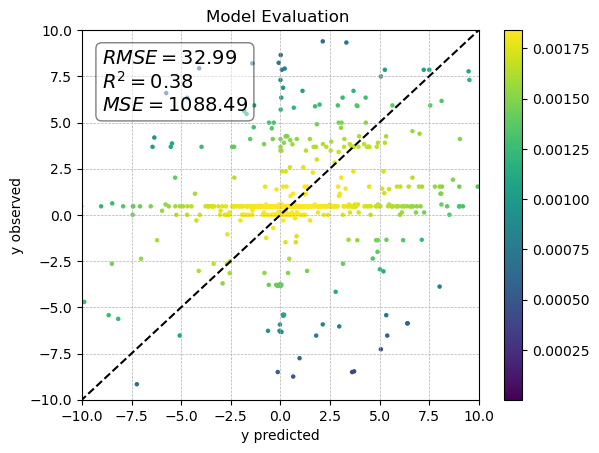

In [31]:

import importlib
import rf_plot 

importlib.reload(rf_plot)  # Reload the module
from rf_plot import plot_results


plot_results(y, rf_fitted.fit(X,y).predict(X), axis_lim= 10, save_dir= '/Users/francesco/Desktop/temporary output', title= 'test')

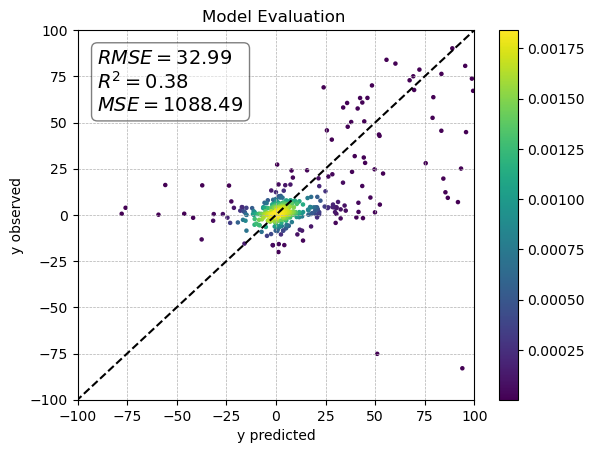

In [32]:
#Now plot the y modelled vs the y observed
#First i need to fit the model on the whole training set

from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rf_fitted.fit(X, y)
y_pred = rf_fitted.predict(X)

y = cv['calving']

#Prova senza reshape
y_modeled = y_pred.copy()
y_data = y.copy().values

xy = np.vstack([y_data,y_modeled])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
ann_plt, y_plt, z = y_data[idx], y_modeled[idx], z[idx]

fig, ax = plt.subplots()
plt.title("Model Evaluation ")

plt.xlabel('y predicted')
plt.ylabel('y observed')
sc = plt.scatter(ann_plt, y_plt, c=z, s=5)

cbar = plt.colorbar(sc)
#cbar.set_label('Point concentration', rotation = 90)

textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_data, y_modeled, squared=False), ),
    r'$R^2=%.2f$' % (r2_score(y_data, y_modeled), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_data, y_modeled), )))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#Now i want to plot the line y = x
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color='black', linestyle='--')

#limit x axis
plt.xlim(-100, 100)
plt.ylim(-100, 100)

#Add a grid
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()



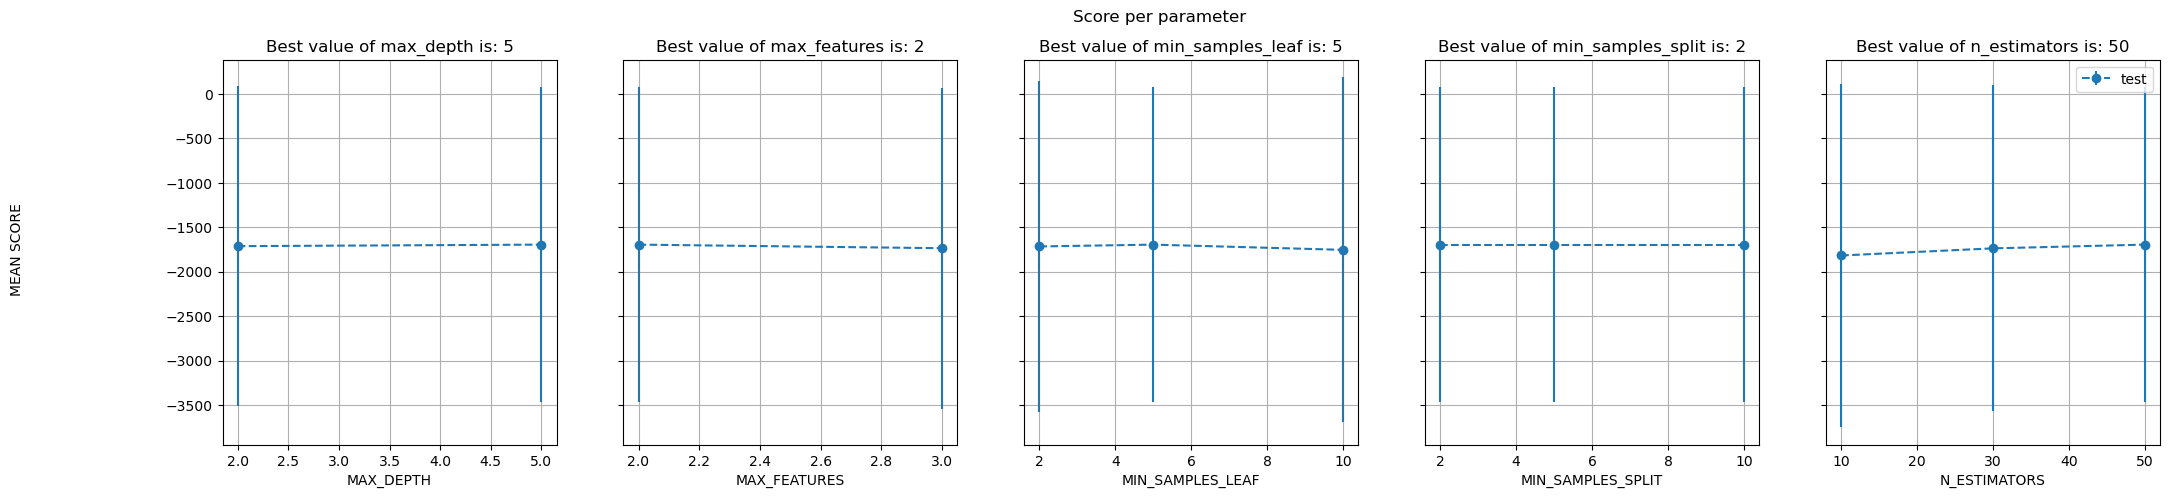

In [33]:
#Trying the plot function

import importlib
import rf_plot 

importlib.reload(rf_plot)  # Reload the module
from rf_plot import plot_gsearch_results

plot_gsearch_results(rf_trained)

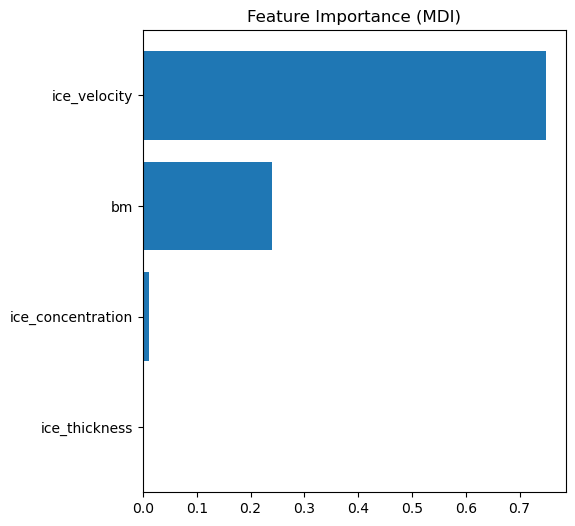

In [18]:
importlib.reload(rf_plot)  # Reload the module
from rf_plot import plot_feature_importance

plot_feature_importance(rf_trained, X, variables_new = None, save_dir=None)

Now i will try to do it again, but introducting random cross validation

In [19]:
#Perform a random cross validation
from sklearn.model_selection import ShuffleSplit

cv_shuffle = ShuffleSplit(n_splits=8, test_size=0.2, random_state=42)
rf_trained_casual = rf_train_and_fit(X, y, cv_shuffle, grid, 'neg_mean_squared_error')

The parameters to test are:  {'n_estimators': [10, 30, 50], 'max_depth': [2, 5], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 5, 10]} 

Fitting 8 folds for each of 54 candidates, totalling 432 fits
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1

In [20]:
print('The best max_depth is: ', rf_trained_casual.best_params_['max_depth']
        , 'The best n_estimators is: ', rf_trained_casual.best_params_['n_estimators']
        , 'The best min_samples_split is: ', rf_trained_casual.best_params_['min_samples_split']
        , 'The best min_samples_leaf is: ', rf_trained_casual.best_params_['min_samples_leaf'])

The best max_depth is:  5 The best n_estimators is:  50 The best min_samples_split is:  2 The best min_samples_leaf is:  5


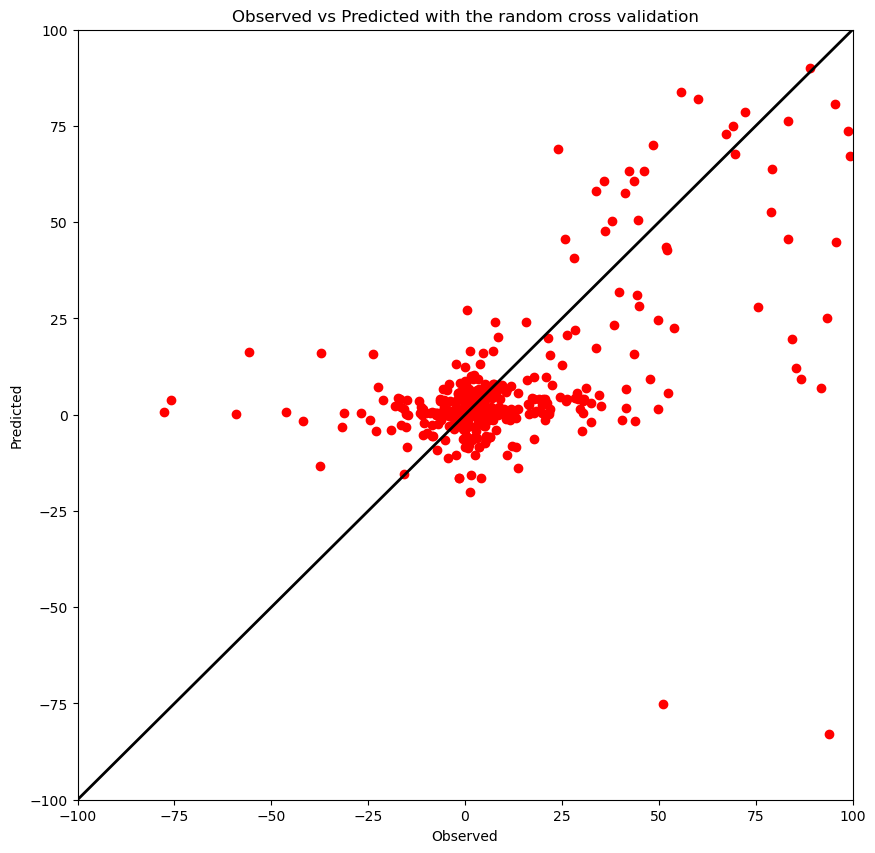

In [21]:
#Get the best parameters

best_n_estimators = rf_trained_casual.best_params_['n_estimators']
best_max_depth = rf_trained_casual.best_params_['max_depth']
best_min_samples_split = rf_trained_casual.best_params_['min_samples_split']
best_min_samples_leaf = rf_trained_casual.best_params_['min_samples_leaf']

#defining the model with the best parameters
rf_best = sklearn.ensemble.RandomForestRegressor(criterion= 'squared_error',
                                                    max_depth=best_max_depth,
                                                    n_estimators=best_n_estimators,
                                                    min_samples_split=best_min_samples_split,
                                                    min_samples_leaf=best_min_samples_leaf,
                                                    random_state=42,
                                                    n_jobs=-1
                                                    )

rf_best.fit(X, y)

y_pred_test = rf_best.predict(X)

#Plotting the results
plt.figure(figsize=(10,10))
plt.scatter(y, y_pred_test, color='red')
plt.xlabel('Observed')
plt.ylabel('Predicted')

x_lim = [-100, 100]
y_lim = [-100, 100]

plt.xlim(x_lim)
plt.ylim(y_lim)

#Plot a line which goes from 9-100,-100 to 100,100
plt.plot([-100, 100], [-100, 100], color='black', linewidth=2)

plt.title('Observed vs Predicted with the random cross validation')
plt.show()


In [22]:

cvl = cross_val_score(rf_best, X, y, cv= cv_shuffle, scoring='neg_mean_squared_error', n_jobs=-1)

print('The mean of the cross validation is: ', np.mean(cvl))
print('The std of the cross validation is: ', np.std(cvl))


The mean of the cross validation is:  -1731.4658976964847
The std of the cross validation is:  965.58668877187


In the next code block i will perform a Grisd-search and a model tuning accorrding to the block division strategy. The order of the blocks is preserved by Kfold, by not mixing the variables. This was re done with the functions later (blocks above)

In [23]:
''' 
#defining the grid for the search
grid = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [5,10,15,20,25,30,35,40,45,50],
    'min_samples_split': [1, 2, 3, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 5],
    'criterion': ['squared_error'],
}


#defining the model
rf = sklearn.ensemble.RandomForestRegressor(random_state=42, n_jobs=-1)

#Splitting the dataset in 8 blocks, according to the folders division. The shuffle is set to False, in order to have the same division as the one i used for the folders
cv_split = KFold(n_splits=8, shuffle=False, random_state=None)

#Perform the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=grid, cv=cv_split, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error') #lower values are better

#Fitting the model
grid_search.fit(cv.drop(['calving'], axis=1), cv['calving'])

print(grid_search.best_params_)
print(grid_search.best_score_)
'''

" \n#defining the grid for the search\ngrid = {\n    'n_estimators': [10, 50, 100, 500, 1000],\n    'max_depth': [5,10,15,20,25,30,35,40,45,50],\n    'min_samples_split': [1, 2, 3, 5, 10, 15, 20],\n    'min_samples_leaf': [1, 2, 3, 5],\n    'criterion': ['squared_error'],\n}\n\n\n#defining the model\nrf = sklearn.ensemble.RandomForestRegressor(random_state=42, n_jobs=-1)\n\n#Splitting the dataset in 8 blocks, according to the folders division. The shuffle is set to False, in order to have the same division as the one i used for the folders\ncv_split = KFold(n_splits=8, shuffle=False, random_state=None)\n\n#Perform the grid search\ngrid_search = GridSearchCV(estimator=rf, param_grid=grid, cv=cv_split, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error') #lower values are better\n\n#Fitting the model\ngrid_search.fit(cv.drop(['calving'], axis=1), cv['calving'])\n\nprint(grid_search.best_params_)\nprint(grid_search.best_score_)\n"

In the next cell i will keep records of the results


In [24]:
grid = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [5,10,15,20,25,30,35,40,45,50],
    'min_samples_split': [1, 2, 3, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 5],
    'criterion': ['squared_error'],
}

{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
-1750.2160949671716

-1750.2160949671716

In [25]:

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

cv_split = KFold(n_splits=8, shuffle=False, random_state=None)
rf_fitted = sklearn.ensemble.RandomForestRegressor(criterion='squared_error', 
                                                   max_depth= 5,#grid_search.best_params_['max_depth'], 
                                                   n_estimators=  500,#grid_search.best_params_['n_estimators'],
                                                   min_samples_split= 10,# grid_search.best_params_['min_samples_split'],
                                                   min_samples_leaf= 5,#grid_search.best_params_['min_samples_leaf'],
                                                   random_state=42,
                                                   n_jobs=-1
                                                   )

cvs = cross_val_score(rf_fitted, cv.drop(['calving'], axis=1), cv['calving'], cv=cv_split, scoring='neg_mean_squared_error', n_jobs=-1)

rf_fitted.fit(cv.drop(['calving'], axis=1), cv['calving'])

RandomForestRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=500, n_jobs=-1, random_state=42)

In [26]:
print('Cross validation scores per fold: ', cvs)
print('Mean cross validation score: ', cvs.mean())
print('Standard deviation: ', cvs.std())

#plot_prediction_per_fold(X, y, fitted_model, idc_list)

Cross validation scores per fold:  [-1343.73747138  -780.61975639   -69.12434561  -587.6120439
 -2106.4922936  -6116.89207849  -226.84582944 -2898.20086747]
Mean cross validation score:  -1766.1905857849088
Standard deviation:  1874.6444991078895


Cross validation scores per fold:  [-2277.51726151  -958.2659416   -142.88396257  -764.34435281
 -1769.59631356 -6455.15156281  -110.56429227 -2180.08198158]
Mean cross validation score:  -1832.3007085891043
Standard deviation:  1917.5773855003897

In [27]:
#len(rf_fitted.predict(cv.drop('calving', axis=1)))
len(cv['calving'])

1248

In [28]:
block here

type: invalid syntax (715661807.py, line 1)

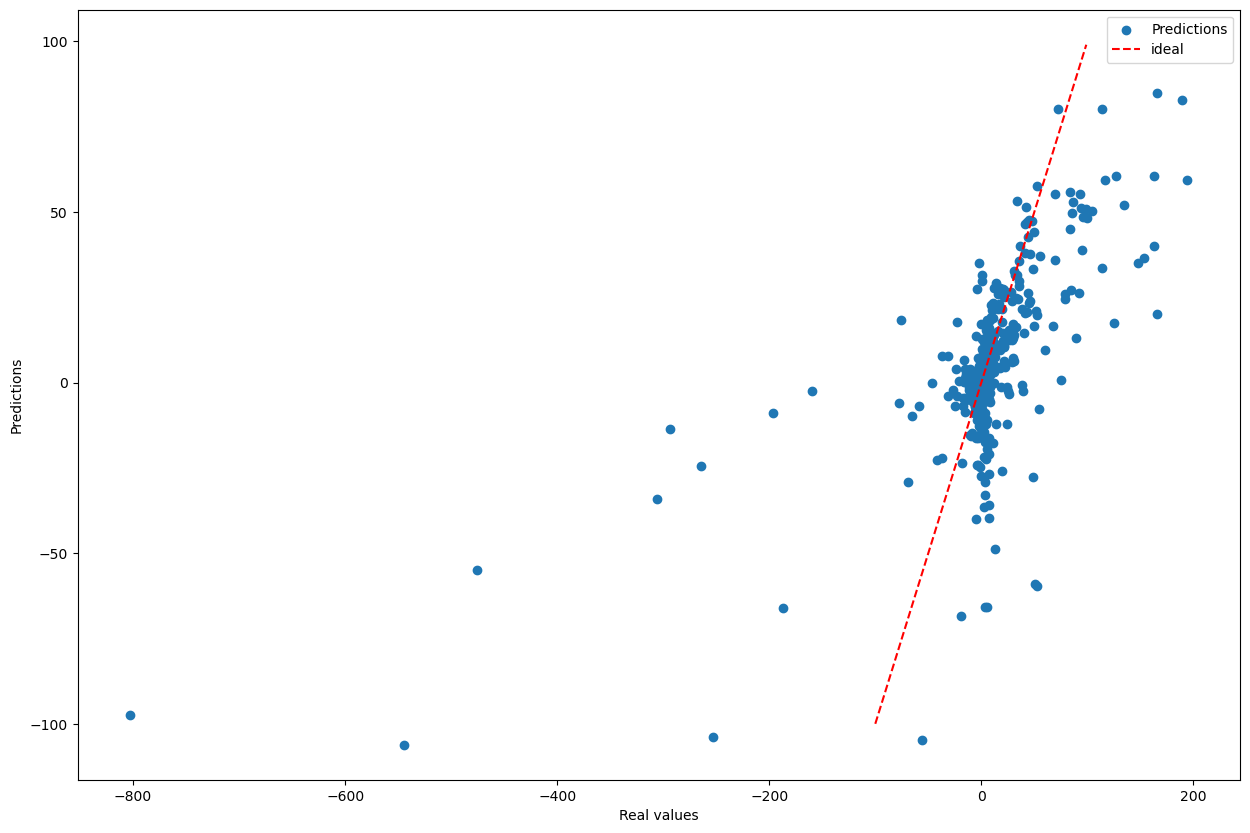

In [ ]:
#Plot the predictions against the real values
plt.figure(figsize=(15,10))
plt.scatter(cv['calving'], rf_fitted.predict(cv.drop('calving', axis=1)), label='Predictions')

#labels
plt.xlabel('Real values')
plt.ylabel('Predictions')

#Plot the 1:1 line
plt.plot(np.arange(-100,100), np.arange(-100,100), label='ideal', color='red', linestyle='--')

#Limit the axis
#plt.xlim(-100, 100)
#plt.ylim(-100, 100)


plt.legend()

Experimenting with functions

type: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

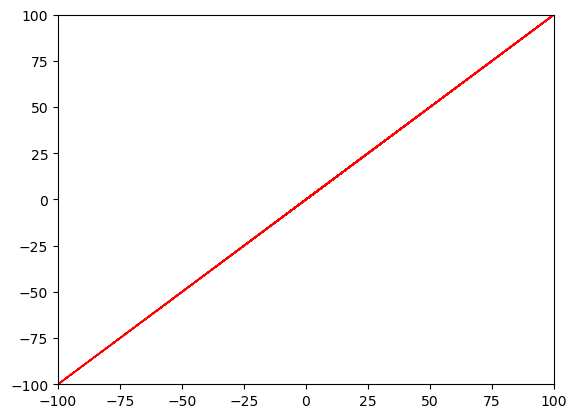

In [ ]:
from scipy.stats import gaussian_kde

#plot also the line of the perfect prediction
plt.plot(cv['calving'], cv['calving'], color='red', linewidth=1, linestyle='--')

#Limit the axis to -100, 100
plt.xlim(-100, 100)
plt.ylim(-100, 100)

x = cv['calving']
y = rf_fitted.predict(cv.drop('calving', axis=1))

xy = np.vstack([x,y])

z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, cmap='viridis')
plt.show()


#cbar = plt.colorbar()
#cbar.set_label('Point Density')

plt.show()



In [ ]:
def plot_prediction_per_fold(X, y, model, idc_list):
    """
    Plot model predictions of model vs. test data y based on 
    folds given by indices X_idc and y_idc.
  
    Parameters:
    X : np.array
        Training dataset of features.
    y : np.array
        Labels of training dataset.
    model : sklearn.model
        Fitted XGBmodel object.
    X_idc : np.array
        Indices of fold splits of features.
    y_idc : np.array
        Indices of fold splits for labels.
    """

    y_test_list = []
    y_pred_list = []

    for train_index, test_index in idc_list:
        # Loops over n_splits iterations and gets train and test splits in each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_test_list.extend(y_test)
        y_pred_list.extend(y_pred)

    # Arrays of predictions and observations for each fold
    y_test_all = np.hstack([*y_test_list])
    y_pred_all = np.hstack([*y_pred_list])

    # Plot predictions and observations for each cross-valiadation fold together
    plot_prediction(y_test_all, y_pred_all, 'Validation', n_toplot=5000)


In the following block i performed (twice) a Random forest grid search, looking for the best hyper-parameters. I did it 'manually', i will now try to re do it with the 
cross validation which is included in the function (previous code blocks)

In [ ]:
# operate cross validation with the block method
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Grid search
'''
grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None,2, 5, 10, 20],
    'criterion': ['squared_error', 'absolute_error']
}
'''
grid = {
    'n_estimators': [10,50,100],
    'max_depth': [None,1],
    'criterion': ['squared_error', 'absolute_error']
}

#rf = RandomForestRegressor(n_estimators=1000, random_state=42)
best_parameters = []
mae_scores = []

for i in range(len(cv_blocks)):
    print(f"Fold {i +1 }:")

    #Extracting the training an testing blocks from the list
    validation_block = cv_blocks[i]
    train_blocks = cv_blocks[:i] + cv_blocks[i+1:]

    #Extracting the training and testing variables and targets
    X_test = validation_block.drop(['calving'], axis=1)
    y_test = validation_block['calving']

    X_train = pd.concat(train_blocks).drop(['calving'], axis=1)
    y_train = pd.concat(train_blocks)['calving']

    # Fit the model on the training data
    rf_cv = GridSearchCV(RandomForestRegressor(), grid)

    # Make predictions on the test data
    rf_cv.fit(X_train, y_train)
    y_pred = rf_cv.predict(X_test)

    '''
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')

    #plot the line y= x (diagonal of the first and third quadrant)
    max_value = np.max([y_test, y_pred])
    min_value = np.min([y_test, y_pred])
    x = np.linspace(min_value, max_value, 100)
    plt.plot(x, x, color='black')
    plt.title('Fold ' + str(i+1))


    plt.show()
    '''

    # Evaluate the model's performance
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    best_parameters.append(rf_cv.best_params_)



Fold 1:


KeyboardInterrupt: 

In [ ]:
mae_scores

[14.941517628205128,
 9.198303205128205,
 3.3142384615384617,
 8.581923076923077,
 13.542544871794872,
 15.390641987179487,
 5.062366666666667,
 10.802583333333333]

In [ ]:
best_parameters

[{'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10}]

In the following block i saved the results fromm the grid search

In [ ]:
#First grid search
grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None,2, 5, 10, 20],
    'criterion': ['squared_error', 'absolute_error']
}


#Mae scores
scores_1 = [13.543539246872902,
 7.1936,
 3.0449211538461536,
 7.448460042735043,
 16.490779807692306,
 15.644852350427351,
 5.029717307692307,
 11.763670210811362]


[{'criterion': 'squared_error', 'max_depth': 20, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 300},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 300},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 100}]

#Second grid search
grid = {
    'n_estimators': [10,50,100],
    'max_depth': [1,2,5],
    'criterion': ['squared_error', 'absolute_error']
}

#Mae scores

scores_2 = [13.75309294871795,
 8.036669551282051,
 3.2670608974358974,
 10.98667982493302,
 14.47870608974359,
 15.34166474358974,
 4.937871794871795,
 11.16877564102564]

[{'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10}]

[{'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10}]

In [ ]:
#Here i will use the best parameters found in the grid search to train the model on the entire dataset.
# I will use the weights to give more importance to the glaciers with a lower mae score

#Scores
weights_1 = [1/score for score in scores_1]
weights_2 = [1/score for score in scores_2]
weights_list = weights_1 + weights_2

#n_estimator
n_estimmator_list = [100, 100, 100, 300, 100, 300, 100, 100, 10, 100, 50, 10, 100, 100, 10, 10]
n_estimator_weighted_avg = np.average(n_estimmator_list, weights=weights_list)

#max_depth
max_depth_list = [20, 2, 2, 2, 2, 2, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1]
max_depth_weighted_avg = np.average(max_depth_list, weights=weights_list)


In [ ]:
#Perform random forest with the best parameters on the whole dataset

train_block = cv_blocks

test_block = dataset.loc[test]


#Extracting the training and testing variables and targets
X_test = test_block.drop(['calving'], axis=1)
y_test = test_block['calving']

X_train = pd.concat(train_blocks).drop(['calving'], axis=1)
y_train = pd.concat(train_blocks)['calving']


In [ ]:
#Perform random forest with the best parameters on the whole dataset

rf_optimized = RandomForestRegressor(n_estimators= int(n_estimator_weighted_avg), max_depth=int(max_depth_weighted_avg), criterion='absolute_error', random_state=42)
rf_optimized.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=2, n_estimators=92,
                      random_state=42)

In [ ]:
# Make predictions on the test data
y_pred = rf_optimized.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mae

3.3510275135869567